# Projet Spark-ML : Prediction de diabète

In [84]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,454 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,514 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,419 kB]
Get:

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Diabetes Health Indicators dataset is available on [Kaggle](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset). The data is collected annually via The Behavioral Risk Factor Surveillance System (BRFSS), conducted by the CDC. Specifically, this dataset is consisted of responses from 253,680 Americans in 2015 on health-related risk behaviors, chronic health conditions, and the use of preventative services. Various attributes in this dataset are used to predict diabetes based on various factors such as the presence of other diseases, BMI, physical activities and others.

Attribute information :

*   HighBP : no high BP, high BP
*   HighChol : no high cholesterol,high cholesterol
*   CholCheck : no cholesterol check in 5 years, cholesterol check in 5 years
*   BMI : continuous
*   Smoker : no, yes
*   Stroke : no, yes
*   HeartDiseaseorAttack :  no, yes
*   PhysActivity : no, yes
*   Fruits : no, yes
*   Veggies : no, yes
*   HvyAlcoholConsum : no, yes
*   AnyHealthcare : no, yes
*   NoDocbcCost : no, yes
*   GenHlth : excellent, very good, good, fair, poor
*   MentHlth : continuous
*   PhysHlth : continuous
*   DiffWalk : no, yes
*   Sex : female, male
*   Age : 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80 or older
*   Education : Never attended school or only kindergarten, Elementary, Some high school, High school graduate, Some college or technical school, College graduate
*   Income : Less than 10,000, Less than 15,000, Less than 20,000, Less than 25,000, Less than 35,000, Less than 50,000 , Less than 75,000, 75,000 or more

Target/Label : Diabetes_012 : no diabetes, prediabetes, diabetes








In [86]:
from pyspark.sql.types import DoubleType, StringType, StructField, StructType

#chargement du dataset

dataset = spark.read.csv("/content/drive/MyDrive/datasets/diabetes_health_indicators.csv",header=True)


## Data Analysis & Preprocessing

In [87]:
dataset.show()

+------------+----------+-------------------+--------------------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+---------+--------+--------+--------+------+-----------+--------------------+-----------------+
|Diabetes_012|    HighBP|           HighChol|           CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|  GenHlth|MentHlth|PhysHlth|DiffWalk|   Sex|        Age|           Education|           Income|
+------------+----------+-------------------+--------------------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+---------+--------+--------+--------+------+-----------+--------------------+-----------------+
| no diabetes|   high BP|   high cholesterol|yes cholesterol c...|40.0|   yes|    no|                  no|          no|    no|    yes|              0.0|          yes|         no|

In [88]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col

#changement du type des colonnes en float

dataset.printSchema()
dataset = dataset.withColumn("BMI", col("BMI").cast("float"))
dataset = dataset.withColumn("HvyAlcoholConsump", col("HvyAlcoholConsump").cast("float"))
dataset = dataset.withColumn("PhysHlth", col("PhysHlth").cast("float"))
dataset.printSchema()
#for col_name in categoricalColumns:
 #   unique_values_count = dataset.select(col_name).distinct().count()
  #  print(f"Unique values count for '{col_name}': {unique_values_count}")

root
 |-- Diabetes_012: string (nullable = true)
 |-- HighBP: string (nullable = true)
 |-- HighChol: string (nullable = true)
 |-- CholCheck: string (nullable = true)
 |-- BMI: string (nullable = true)
 |-- Smoker: string (nullable = true)
 |-- Stroke: string (nullable = true)
 |-- HeartDiseaseorAttack: string (nullable = true)
 |-- PhysActivity: string (nullable = true)
 |-- Fruits: string (nullable = true)
 |-- Veggies: string (nullable = true)
 |-- HvyAlcoholConsump: string (nullable = true)
 |-- AnyHealthcare: string (nullable = true)
 |-- NoDocbcCost: string (nullable = true)
 |-- GenHlth: string (nullable = true)
 |-- MentHlth: string (nullable = true)
 |-- PhysHlth: string (nullable = true)
 |-- DiffWalk: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Income: string (nullable = true)

root
 |-- Diabetes_012: string (nullable = true)
 |-- HighBP: string (nullable = true)
 |-- HighChol: 

In [89]:
#pour voir la distribution du label

dataset.groupBy("Diabetes_012").count().show()

+------------+------+
|Diabetes_012| count|
+------------+------+
| prediabetes|  4631|
|    diabetes| 35346|
| no diabetes|213703|
+------------+------+



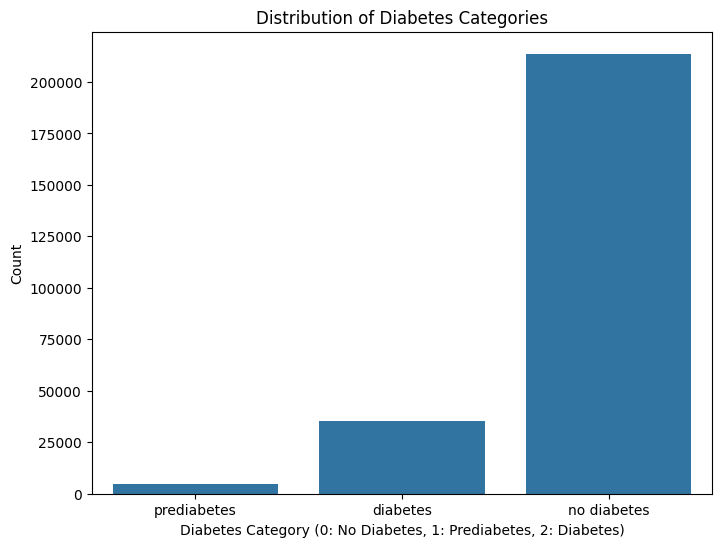

In [90]:
#affichage de la distribution du label

import matplotlib.pyplot as plt
import seaborn as sns

diabetes_counts = dataset.groupBy("Diabetes_012").count().toPandas()

plt.figure(figsize=(8,6))
sns.barplot(x="Diabetes_012", y="count", data=diabetes_counts)
plt.title("Distribution of Diabetes Categories")
plt.xlabel("Diabetes Category (0: No Diabetes, 1: Prediabetes, 2: Diabetes)")
plt.ylabel("Count")
plt.show()

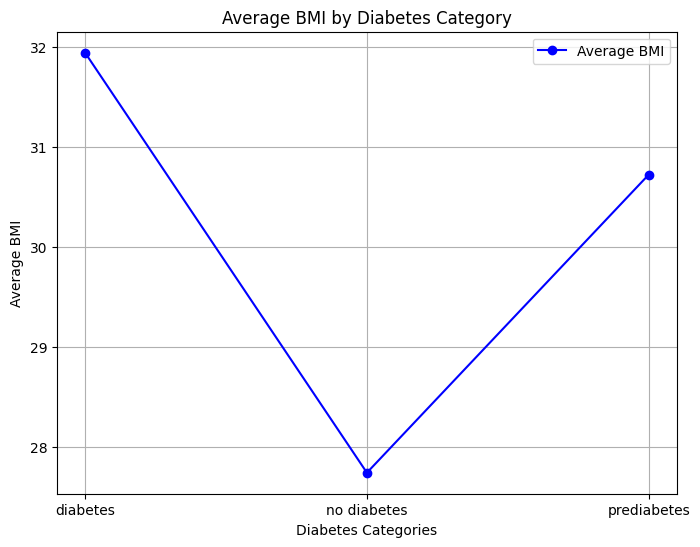

In [91]:
#calcul et affichage de BMI selon des labels

diabetes_bmi = dataset.select("BMI", "Diabetes_012").toPandas()

bmi_avg = diabetes_bmi.groupby("Diabetes_012")["BMI"].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.plot(bmi_avg["Diabetes_012"], bmi_avg["BMI"], marker="o", linestyle="-", color="blue", label="Average BMI")
plt.title("Average BMI by Diabetes Category")
plt.xlabel("Diabetes Categories")
plt.ylabel("Average BMI")
plt.legend()
plt.grid(True)
plt.show()


In [92]:
#analyse de la correlation entre diabète et cholestérol

diabetes_highchol = dataset.select("Diabetes_012", "HighChol").toPandas()

highchol_counts = diabetes_highchol.groupby("Diabetes_012")["HighChol"].value_counts().unstack(fill_value=0).reset_index()
#unstack => pour créer nouvelle colonne

print(highchol_counts)


HighChol Diabetes_012  high cholesterol  no high cholesterol
0            diabetes             23686                11660
1         no diabetes             81030               132673
2         prediabetes              2875                 1756


<Figure size 800x600 with 0 Axes>

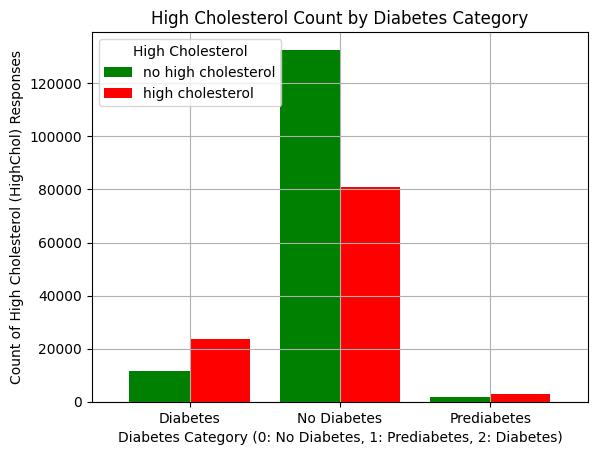

In [93]:
#affichage du résultat

plt.figure(figsize=(8, 6))

highchol_counts.set_index('Diabetes_012')[['no high cholesterol', 'high cholesterol']].plot(kind='bar', color=['green', 'red'], width=0.8)

plt.title("High Cholesterol Count by Diabetes Category")
plt.xlabel("Diabetes Category (0: No Diabetes, 1: Prediabetes, 2: Diabetes)")
plt.ylabel("Count of High Cholesterol (HighChol) Responses")
plt.xticks([0, 1, 2], ['Diabetes', 'No Diabetes', 'Prediabetes'], rotation=0)  # Custom x-ticks and no rotation

plt.legend(title="High Cholesterol", loc="upper left")
plt.grid(True)
plt.show()


In [94]:
#analyse de la correlation entre diabète et hypertension

diabetes_highBP = dataset.select("Diabetes_012", "HighBP").toPandas()

#unstack => pour créer nouvelle colonne
highBP_counts = diabetes_highBP.groupby("Diabetes_012")["HighBP"].value_counts().unstack(fill_value=0).reset_index()

print(highBP_counts)

HighBP Diabetes_012  high BP  no high BP
0          diabetes    26604        8742
1       no diabetes    79312      134391
2       prediabetes     2913        1718


<Figure size 800x600 with 0 Axes>

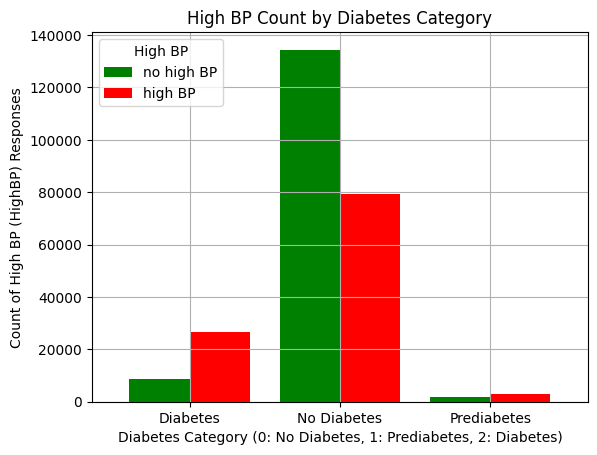

In [95]:
#affichage du résultat

plt.figure(figsize=(8, 6))

highBP_counts.set_index('Diabetes_012')[['no high BP', 'high BP']].plot(kind='bar', color=['green', 'red'], width=0.8)

plt.title("High BP Count by Diabetes Category")
plt.xlabel("Diabetes Category (0: No Diabetes, 1: Prediabetes, 2: Diabetes)")
plt.ylabel("Count of High BP (HighBP) Responses")
plt.xticks([0, 1, 2], ['Diabetes', 'No Diabetes', 'Prediabetes'], rotation=0)  # Custom x-ticks and no rotation

plt.legend(title="High BP", loc="upper left")
plt.grid(True)
plt.show()

In [96]:
#analyse de la correlation entre diabète et l'accès aux soins

diabetes_AnyHealthcare = dataset.select("Diabetes_012", "AnyHealthcare").toPandas()

AnyHealthcare_counts = diabetes_AnyHealthcare.groupby("Diabetes_012")["AnyHealthcare"].value_counts().unstack(fill_value=0).reset_index()

print(AnyHealthcare_counts)

AnyHealthcare Diabetes_012     no     yes
0                 diabetes   1422   33924
1              no diabetes  10741  202962
2              prediabetes    254    4377


In [97]:
#analyse de la correlation entre diabète et activité physique

diabetes_PhysActivity = dataset.select("Diabetes_012", "PhysActivity").toPandas()

PhysActivity_counts = diabetes_PhysActivity.groupby("Diabetes_012")["PhysActivity"].value_counts().unstack(fill_value=0).reset_index()

print(PhysActivity_counts)

PhysActivity Diabetes_012     no     yes
0                diabetes  13059   22287
1             no diabetes  47212  166491
2             prediabetes   1489    3142


In [98]:
#supression des colonnes non-importants

dataset = dataset.drop("Education","CholCheck","AnyHealthcare","NoDocbcCost","MentHlth","DiffWalk","Income","PhysActivity")
dataset.show()

#définition des colonnes catégoriques et numériques

continuousColumns = ["BMI", "HvyAlcoholConsump", "PhysHlth"]
categoricalColumns = ["HighBP","HighChol","Smoker","Stroke","HeartDiseaseorAttack","Fruits","Veggies","GenHlth","Sex","Age"]
cols = dataset.columns

+------------+----------+-------------------+----+------+------+--------------------+------+-------+-----------------+---------+--------+------+-----------+
|Diabetes_012|    HighBP|           HighChol| BMI|Smoker|Stroke|HeartDiseaseorAttack|Fruits|Veggies|HvyAlcoholConsump|  GenHlth|PhysHlth|   Sex|        Age|
+------------+----------+-------------------+----+------+------+--------------------+------+-------+-----------------+---------+--------+------+-----------+
| no diabetes|   high BP|   high cholesterol|40.0|   yes|    no|                  no|    no|    yes|              0.0|     poor|    15.0|female|      60-64|
| no diabetes|no high BP|no high cholesterol|25.0|   yes|    no|                  no|    no|     no|              0.0|     good|     0.0|female|      50-54|
| no diabetes|   high BP|   high cholesterol|28.0|    no|    no|                  no|   yes|     no|              0.0|     poor|    30.0|female|      60-64|
| no diabetes|   high BP|no high cholesterol|27.0|    no| 

## Categorical Data Encoding

In [99]:
#définition du pipeline avec traitements partie catégorique

stages = []
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    from pyspark.ml.feature import OneHotEncoder
    encoder = OneHotEncoder(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol="Diabetes_012", outputCol="label")
stages += [label_stringIdx]



## Numerical Data Scaling

In [100]:
numerical_vector_assembler = VectorAssembler(inputCols=continuousColumns,outputCol='numerical_feature_vector')

scaler = StandardScaler(inputCol='numerical_feature_vector',outputCol='scaled_numerical_feature_vector',withStd=True, withMean=True)

stages += [numerical_vector_assembler, scaler]

In [101]:
assemblerInputs = [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs + ['scaled_numerical_feature_vector'], outputCol="features")
stages += [assembler]
print(stages)

[StringIndexer_3dc230b2a117, OneHotEncoder_9315435e9835, StringIndexer_f878f651cb23, OneHotEncoder_6a596291216b, StringIndexer_9a84adbda66e, OneHotEncoder_d076256ad643, StringIndexer_bff928990327, OneHotEncoder_b2b98fc7c5e8, StringIndexer_fd9c13e9188c, OneHotEncoder_0e6fb9e94695, StringIndexer_aee42ff2ebca, OneHotEncoder_acd20bd487f7, StringIndexer_a0321d64fad6, OneHotEncoder_51634fb88858, StringIndexer_ecb32fc1d53f, OneHotEncoder_ff610693c6dd, StringIndexer_f5cda12037cd, OneHotEncoder_dd7da83a3aca, StringIndexer_0b6b47a46a08, OneHotEncoder_954d977e4f2d, StringIndexer_ce2d0b2e60dd, VectorAssembler_852bcb0223c4, StandardScaler_2825c398939a, VectorAssembler_17ffde302c9a]


In [102]:
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(dataset)
preppedDataDF = pipelineModel.transform(dataset)

In [103]:
selectedcols = ["label", "features"] + cols
dataset = preppedDataDF.select(selectedcols)
dataset.show()
dataset.select("features").show(truncate=False)

+-----+--------------------+------------+----------+-------------------+----+------+------+--------------------+------+-------+-----------------+---------+--------+------+-----------+
|label|            features|Diabetes_012|    HighBP|           HighChol| BMI|Smoker|Stroke|HeartDiseaseorAttack|Fruits|Veggies|HvyAlcoholConsump|  GenHlth|PhysHlth|   Sex|        Age|
+-----+--------------------+------------+----------+-------------------+----+------+------+--------------------+------+-------+-----------------+---------+--------+------+-----------+
|  0.0|(27,[3,4,6,11,12,...| no diabetes|   high BP|   high cholesterol|40.0|   yes|    no|                  no|    no|    yes|              0.0|     poor|    15.0|female|      60-64|
|  0.0|(27,[0,1,3,4,8,11...| no diabetes|no high BP|no high cholesterol|25.0|   yes|    no|                  no|    no|     no|              0.0|     good|     0.0|female|      50-54|
|  0.0|(27,[2,3,4,5,11,1...| no diabetes|   high BP|   high cholesterol|28.0|   

In [104]:
#séparation du dataset pour train et test

(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=42)
print(trainingData.count())
print(testData.count())


177562
76118


## Model Evaluation

In [105]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

models = {
    'LogisticRegression': LogisticRegression(labelCol="label", featuresCol="features"),
    'DecisionTree': DecisionTreeClassifier(labelCol="label", featuresCol="features"),
    'RandomForest': RandomForestClassifier(labelCol="label", featuresCol="features")
}

for model_name, model in models.items():
    trained_model = model.fit(trainingData)
    predictions = trained_model.transform(testData)
    accuracy = evaluator.evaluate(predictions)
    print(f"Accuracy of {model_name} model: {accuracy}")


Accuracy of LogisticRegression model: 0.8451483223416275
Accuracy of DecisionTree model: 0.8448987098977903
Accuracy of RandomForest model: 0.840891773299351


## Parameters Tuning for LR

In [106]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

model=LogisticRegression(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()
             .addGrid(model.regParam, [0.001, 0.5, 2.0])
             .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(model.maxIter, [1, 10, 100])
             .build())

cv = CrossValidator(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)

0.8453059723061562

In [107]:
bestModel = cvModel.bestModel
bestRegParam = bestModel.getRegParam()
bestElasticNetParam = bestModel.getElasticNetParam()
bestMaxIter = bestModel.getMaxIter()

print(f"Best regParam: {bestRegParam}")
print(f"Best elasticNetParam: {bestElasticNetParam}")
print(f"Best maxIter: {bestMaxIter}")

Best regParam: 0.001
Best elasticNetParam: 0.0
Best maxIter: 10


## Parameters Tuning for DT

In [108]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

model=DecisionTreeClassifier(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()
             .addGrid(model.maxDepth, [1, 2, 5, 10])
             .addGrid(model.maxBins, [10, 40, 80])
             .build())

cv = CrossValidator(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)

0.8448987098977903

In [109]:
bestModel = cvModel.bestModel
bestMaxDepth = bestModel.getMaxDepth()
bestMaxBins = bestModel.getMaxBins()

print(f"Best maxDepth: {bestMaxDepth}")
print(f"Best maxBins: {bestMaxBins}")


Best maxDepth: 5
Best maxBins: 40


## Parameters Tuning for RF

In [110]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

model=RandomForestClassifier(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()
             .addGrid(model.maxDepth, [2, 4, 6])
             .addGrid(model.maxBins, [20, 60])
             .addGrid(model.numTrees, [5, 20])
             .build())

cv = CrossValidator(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)

0.8410625607609238

In [111]:
bestModel = cvModel.bestModel
bestMaxDepth = bestModel.getMaxDepth()
bestMaxBins = bestModel.getMaxBins()

print(f"Best maxDepth: {bestMaxDepth}")
print(f"Best maxBins: {bestMaxBins}")


Best maxDepth: 6
Best maxBins: 20


# Correction after presentation with prof.

## LR

In [112]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

model=LogisticRegression(labelCol="label", featuresCol="features")

trained_model = model.fit(trainingData)
predictions = trained_model.transform(testData)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of {model} model: {accuracy}")

class_labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

for label in class_labels:
  evaluator.setMetricName("precisionByLabel")
  evaluator.setMetricLabel(label)
  precision = evaluator.evaluate(predictions)
  print(f"Precision for class {label}: {precision}")


Accuracy of LogisticRegression_408944faf77e model: 0.8451483223416275
Precision for class 0.0: 0.8594982275837433
Precision for class 1.0: 0.532074340527578
Precision for class 2.0: 0.0


## DT

In [113]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

model=DecisionTreeClassifier(labelCol="label", featuresCol="features")

trained_model = model.fit(trainingData)
predictions = trained_model.transform(testData)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of {model} model: {accuracy}")

class_labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

for label in class_labels:
  evaluator.setMetricName("precisionByLabel")
  evaluator.setMetricLabel(label)
  precision = evaluator.evaluate(predictions)
  print(f"Precision for class {label}: {precision}")

Accuracy of DecisionTreeClassifier_ddf594e658fa model: 0.8448987098977903
Precision for class 0.0: 0.8565255912219724
Precision for class 1.0: 0.5350526698147475
Precision for class 2.0: 0.0


## RF

In [114]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

model=RandomForestClassifier(labelCol="label", featuresCol="features")

trained_model = model.fit(trainingData)
predictions = trained_model.transform(testData)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of {model} model: {accuracy}")

class_labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

for label in class_labels:
  evaluator.setMetricName("precisionByLabel")
  evaluator.setMetricLabel(label)
  precision = evaluator.evaluate(predictions)
  print(f"Precision for class {label}: {precision}")

Accuracy of RandomForestClassifier_525c1bd81364 model: 0.840891773299351
Precision for class 0.0: 0.840891773299351
Precision for class 1.0: 0.0
Precision for class 2.0: 0.0


## Sampling of dominant class (so that it become same size as the second dominant class)

In [115]:
# compter l'occurrence de chaque classe
class_counts = trainingData.groupBy("label").count()
class_counts.show()

# trouver la classe dominante et seconde dominante
sorted_counts = class_counts.orderBy("count", ascending=False).collect()

# compter la classe seconde dominante
second_dominant_count = sorted_counts[1]["count"]

# obtenir label de la classe dominante
dominant_class = sorted_counts[0]["label"]
dominant_class_count = sorted_counts[0]["count"]

# échantillonnage de la classe dominante
fraction = second_dominant_count / dominant_class_count
dominant_class_df = trainingData.filter(trainingData.label == dominant_class).sample(False, fraction, seed=60)

other_classes_df = trainingData.filter(trainingData.label != dominant_class)

# combiner la classe dominante échantilonnée et les autres classes
balanced_training_data = dominant_class_df.union(other_classes_df)
balanced_training_data.groupBy("label").count().show()


+-----+------+
|label| count|
+-----+------+
|  0.0|149696|
|  1.0| 24639|
|  2.0|  3227|
+-----+------+

+-----+-----+
|label|count|
+-----+-----+
|  0.0|24943|
|  1.0|24639|
|  2.0| 3227|
+-----+-----+



In [116]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

model=LogisticRegression(labelCol="label", featuresCol="features")

trained_model = model.fit(balanced_training_data)
predictions = trained_model.transform(testData)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of {model} model: {accuracy}")

class_labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

for label in class_labels:
  evaluator.setMetricName("precisionByLabel")
  evaluator.setMetricLabel(label)
  precision = evaluator.evaluate(predictions)
  print(f"Precision for class {label}: {precision}")


Accuracy of LogisticRegression_a2b752889afc model: 0.7212223127249796
Precision for class 0.0: 0.9387554036392882
Precision for class 1.0: 0.3111473297198954
Precision for class 2.0: 0.0


In [117]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

model=DecisionTreeClassifier(labelCol="label", featuresCol="features")

trained_model = model.fit(balanced_training_data)
predictions = trained_model.transform(testData)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of {model} model: {accuracy}")

class_labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

for label in class_labels:
  evaluator.setMetricName("precisionByLabel")
  evaluator.setMetricLabel(label)
  precision = evaluator.evaluate(predictions)
  print(f"Precision for class {label}: {precision}")

Accuracy of DecisionTreeClassifier_02f456276a42 model: 0.7221025250269318
Precision for class 0.0: 0.9266914352757137
Precision for class 1.0: 0.3032268396188646
Precision for class 2.0: 0.0


In [118]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

model=RandomForestClassifier(labelCol="label", featuresCol="features")

trained_model = model.fit(balanced_training_data)
predictions = trained_model.transform(testData)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of {model} model: {accuracy}")

class_labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

for label in class_labels:
  evaluator.setMetricName("precisionByLabel")
  evaluator.setMetricLabel(label)
  precision = evaluator.evaluate(predictions)
  print(f"Precision for class {label}: {precision}")

Accuracy of RandomForestClassifier_f9ca12b6b224 model: 0.705680653721853
Precision for class 0.0: 0.9357943119793163
Precision for class 1.0: 0.29615834063686824
Precision for class 2.0: 0.0


## Sampling of dominant class (so that all classes become same size)

In [119]:
class_counts = trainingData.groupBy("label").count()
class_counts.show()

sorted_counts = class_counts.orderBy("count", ascending=False).collect()

dominant_class = sorted_counts[0]["label"]
dominant_class_count = sorted_counts[0]["count"]

second_dominant_class = sorted_counts[1]["label"]
second_dominant_class_count = sorted_counts[1]["count"]

min_count = sorted_counts[-1]["count"]

dominant_fraction = min_count / dominant_class_count
second_dominant_fraction = min_count / second_dominant_class_count

dominant_class_df = trainingData.filter(trainingData.label == dominant_class).sample(False, dominant_fraction, seed=42)
second_dominant_class_df = trainingData.filter(trainingData.label == second_dominant_class).sample(False, second_dominant_fraction, seed=42)

other_classes_df = trainingData.filter((trainingData.label != dominant_class) & (trainingData.label != second_dominant_class))

balanced_training_data = dominant_class_df.union(second_dominant_class_df).union(other_classes_df)

balanced_training_data.groupBy("label").count().show()


+-----+------+
|label| count|
+-----+------+
|  0.0|149696|
|  1.0| 24639|
|  2.0|  3227|
+-----+------+

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 3352|
|  1.0| 3341|
|  2.0| 3227|
+-----+-----+



In [120]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

model=LogisticRegression(labelCol="label", featuresCol="features")

trained_model = model.fit(balanced_training_data)
predictions = trained_model.transform(testData)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of {model} model: {accuracy}")

class_labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

for label in class_labels:
  evaluator.setMetricName("precisionByLabel")
  evaluator.setMetricLabel(label)
  precision = evaluator.evaluate(predictions)
  print(f"Precision for class {label}: {precision}")

Accuracy of LogisticRegression_375c2c328860 model: 0.645997004650674
Precision for class 0.0: 0.9485272641488238
Precision for class 1.0: 0.35245945511962745
Precision for class 2.0: 0.028547114343184278


In [121]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

model=DecisionTreeClassifier(labelCol="label", featuresCol="features")

trained_model = model.fit(balanced_training_data)
predictions = trained_model.transform(testData)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of {model} model: {accuracy}")

class_labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

for label in class_labels:
  evaluator.setMetricName("precisionByLabel")
  evaluator.setMetricLabel(label)
  precision = evaluator.evaluate(predictions)
  print(f"Precision for class {label}: {precision}")

Accuracy of DecisionTreeClassifier_d21865dbd4b6 model: 0.6152946740586983
Precision for class 0.0: 0.9421470096735473
Precision for class 1.0: 0.34081643458463495
Precision for class 2.0: 0.025027129679869777


In [122]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

model=RandomForestClassifier(labelCol="label", featuresCol="features")

trained_model = model.fit(balanced_training_data)
predictions = trained_model.transform(testData)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of {model} model: {accuracy}")

class_labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()

for label in class_labels:
  evaluator.setMetricName("precisionByLabel")
  evaluator.setMetricLabel(label)
  precision = evaluator.evaluate(predictions)
  print(f"Precision for class {label}: {precision}")

Accuracy of RandomForestClassifier_02c74e30d853 model: 0.6610919887543025
Precision for class 0.0: 0.9412679294864776
Precision for class 1.0: 0.31852883060894555
Precision for class 2.0: 0.029932803909590716


### We can observe that with equally distributed classes, the random forest method has the highest accuracy although the accuracy for second and least dominant classes remain low (non zero).